# 量子数え上げ

このアルゴリズムを理解するためには、最初にグローバーのアルゴリズムと量子位相推定アルゴリズムの両方を理解することは大切なことです。

グローバーアルゴリズムがオラクルの解を見つけようとするのに対し、量子数え上げのアルゴリズムは、この問題の解の数を見つけます。

このアルゴリズムは量子探索アルゴリズムと量子位相推定アルゴリズムの両方を結びつけるので、大変興味深いものです。


## 目次

1. [概要](#overview)    
    1.1 [知識](#intuition)    
    1.2 [より詳しく見る](#closer_look)    
2. [コード](#code)    
    2.1 [コードの初期化](#init_code)    
    2.2 [制御されたグローバ反復](#cont_grover)    
    2.3 [逆量子フーリエ変換](#inv_qft)    
    2.4 [合わせてみましょう！](#putting_together)    
3. [シミュレーション](#simulating)    
4. [解の数(M)を見つける](#finding_m)
5. [練習問題](#exercises)
6. [参考文献](#references)

## 1. 概要<a id='overview'></a>

### 1.1 知識<a id='intuition'></a>

グローバー探索の反復の固有値を見つけるために量子位相推定アルゴリズムを使います。

グローバー探索の反復演算$G$は、$|\omega\rangle$、$|s'\rangle$基底で、状態ベクトルを$\theta$回転させるものであることを覚えているでしょう。：

![image1](images/quantum_counting1.svg)


探索空間の解の数の割合は基底$|s\rangle$と基底$|s’\rangle$の差に依存します。

例えば、もしたくさんの解がないならば、基底$|s\rangle$は基底$|s’\rangle$に近く、そして角度$\theta$ はとても小さいでしょう。

グローバーの反復の固有値は 𝑒±𝑖𝜃であることが分かり、量子位相推定を使って、解の数(M)を推定します。

### 1.2 より詳しく見る <a id='closer_look'></a>

$|\omega\rangle$、$|s'\rangle$ 基底で、グローバーの反復演算は以下の行列で書き表せます。：

$$
G =
\begin{pmatrix}
\cos{\theta} && -\sin{\theta}\\
\sin{\theta} && \cos{\theta}
\end{pmatrix}
$$

行列$G$は以下の固有ベクトルを持ちます。:

$$
\begin{pmatrix}
-i\\
1
\end{pmatrix}
,
\begin{pmatrix}
i\\
1
\end{pmatrix}
$$

前述の通り、固有値は$e^{\pm i\theta}$です。
幸運なことに、$|s\rangle$の状態は、$|\omega\rangle$と$|s’\rangle$で張られている空間にあるため、

$|s’\rangle$は以下のように２つのベクトルの重ね合わせとなります。

$$
|s\rangle = \alpha |\omega\rangle + \beta|s'\rangle
$$

その結果、QPEアルゴリズムの出力は2つの位相の重ね合わせになり、レジスターを測定すると、これら2つの値のいずれかが得られます！

次に、いくつかの簡単な数学を使用して、$𝑀$の推定値を取得できます。

![image2](images/quantum_counting2.svg)


## 2.　コード <a id='code'></a>

### 2.1 コードの初期化 <a id='init_code'></a>

最初に、ここで必要なものを全てインポートしましょう。

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

このガイドで選択したカウント量子ビット数である、$t = 4$量子ビットでゲートを作成します。

最後の4量子ビット($n = 4$)を通して`探索`するものとして選ぶでしょう。

そのようなことを通して、回路のブロックを作り始めることができます。

### 2.2 制御されたグローバー探索の反復<a id='cont_grover'></a>

グローバーのアルゴリズムの章で、既に「グローバー反復」を扱いました。

これは、拡散オペレーターが組み込まれた、16の状態($𝑁=2^𝑛=16$)のうち５つの解 ($𝑀$=5) をもつオラクルの例です。：

In [8]:
def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # 回路を実行する
    qc = QuantumCircuit(4)
    # オラクル
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

Python関数は入力を受け取らず、4量子ビットの`QuantumCircuit`オブジェクトを返すことに注意してください。

過去に作成した関数は既存の回路を変更した可能性がありますが、

この関数は`QuantumCircuit`オブジェクトを単純な制御ゲートに変えることができます。

そして、回路から制御ゲートを作り出すために`.to_gate()`と`.control()`を使うことができます。 

私たちはグローバーの反復演算を`grit`と呼び、制御グローバー反復演算を`cgrit`と呼びます。:

In [9]:
# 制御されたグローバーの作成
grit = example_grover_iteration().to_gate()
cgrit = grit.control()
cgrit.label = "Grover"

### 2.3 逆量子フーリエ変換<a id='inv_qft'></a>

これから、逆量子フーリエ変換を作成する必要があります。

このコードはn量子ビットのQFTで実装します。

In [10]:
def qft(n):
    #n量子ビットのQFT回路を作成
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        #swapゲートなしで回路で最初にn量子ビットのQFTを実装する
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

ここでも、別の`QuantumCircuit` オブジェクトを返すことを選んだことに注意してください。

これは、ゲートを簡単に反転できるようにするためです。

このガイドで選択したカウント量子ビット数である、$t = 4$量子ビットでゲートを作成します。

In [11]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"

<ipython-input-10-0c52c592a2a2>:17: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(np.pi/2**(n-qubit), qubit, n)


### 2.4 合わせてみましょう！ <a id='putting_together'></a>
ここで、回路を完成するために必要な全てのものが揃いました。

これを全て合わせてみましょう！

最初に、全ての量子ビットを$|+\rangle$の状態にする必要があります。:

In [12]:
# 量子回路の作成
t = 4   # カウントする量子ビットの数
n = 4   # 探索する量子ビットの数
qc = QuantumCircuit(n+t, t) # 古典ビットとn+t量子ビットの回路
# 全ての量子ビットを |+>に初期化する
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw()

┌───┐┌─────────┐                                                       »
q_0: ┤ H ├┤0        ├───────────────────────────────────────────────────────»
     ├───┤│         │┌─────────┐┌─────────┐                                 »
q_1: ┤ H ├┤         ├┤0        ├┤0        ├─────────────────────────────────»
     ├───┤│         ││         ││         │┌─────────┐┌─────────┐┌─────────┐»
q_2: ┤ H ├┤         ├┤         ├┤         ├┤0        ├┤0        ├┤0        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_3: ┤ H ├┤         ├┤         ├┤         ├┤         ├┤         ├┤         ├»
     ├───┤│  Grover ││         ││         ││         ││         ││         │»
q_4: ┤ H ├┤1        ├┤1 Grover ├┤1 Grover ├┤1        ├┤1        ├┤1        ├»
     ├───┤│         ││         ││         ││  Grover ││  Grover ││  Grover │»
q_5: ┤ H ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_6: ┤ H ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_7: ┤ H ├┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────────────────────────────────»
«     ┌─────────┐                                                       »
«q_2: ┤0        ├───────────────────────────────────────────────────────»
«     │         │┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
«q_3: ┤         ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_4: ┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
«     │  Grover ││         ││         ││         ││         ││         │»
«q_5: ┤2        ├┤2 Grover ├┤2 Grover ├┤2 Grover ├┤2 Grover ├┤2 Grover ├»
«     │         ││         ││         ││         ││         ││         │»
«q_6: ┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_7: ┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├»
«     └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                      ┌───────┐┌─┐         
«q_0: ─────────────────────────────────┤0      ├┤M├─────────
«                                      │       │└╥┘┌─┐      
«q_1: ─────────────────────────────────┤1      ├─╫─┤M├──────
«                                      │  QFT† │ ║ └╥┘┌─┐   
«q_2: ─────────────────────────────────┤2      ├─╫──╫─┤M├───
«     ┌─────────┐┌─────────┐┌─────────┐│       │ ║  ║ └╥┘┌─┐
«q_3: ┤0        ├┤0        ├┤0        ├┤3      ├─╫──╫──╫─┤M├
«     │         ││         ││         │└───────┘ ║  ║  ║ └╥┘
«q_4: ┤1        ├┤1        ├┤1        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_5: ┤2 Grover ├┤2 Grover ├┤2 Grover ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_6: ┤3        ├┤3        ├┤3        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_7: ┤4        ├┤4        ├┤4        ├──────────╫──╫──╫──╫─
«     └─────────┘└─────────┘└─────────┘          ║  ║  ║  ║ 
«c: 4/═══════════════════════════════════════════╩══╩══╩══╩═
«                  

素晴らしい！では、結果をいくつか確かめましょう。

## 3. シミュレーション<a id='simulating'></a>

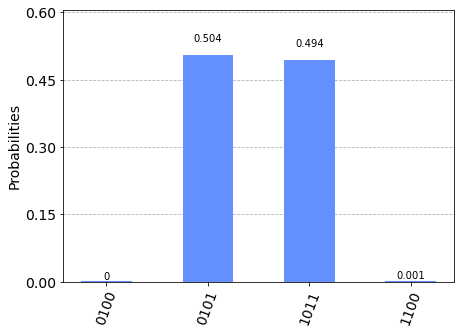

In [13]:
# 実行してみましょう。そして結果を確かめてみましょう。
emulator = Aer.get_backend('qasm_simulator')
job = execute(qc, emulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)

残りの測定値より確率が高い２つの値(0101と1011)をシミュレーションから確認することができます。

これら２つの値は$e^{i\theta}$と$e^{-i\theta}$に対応します。

しかし、まだ解の数を確かめることはできません。

この情報を取得するためにもう少し処理する必要があるため、最初に出力を処理できるもの（`int`）に入れましょう。

出力データから最も可能性の高い結果の文字列を取得します。

In [14]:
measured_str = max(hist, key=hist.get)

これを整数として保存しましょう:

In [15]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 5


## 4. 解の数(M)を見つける <a id='finding_m'></a>

レジスターの10進の整数出力、カウント量子ビット（$t$）の数、および探索量子ビット（$n$）の数を入力とする関数`calculate_M()`を作成します。

最初に、`measured_int`から$\theta$を得ましょう。

QPEは固有値$e^{2\pi i\phi}$から$\text{測定値} = 2^n \phi$として得るため、$\theta$を得るために以下をする必要があります。：

$$
\theta = \text{測定値}\times\frac{2\pi}{2^t}
$$

または、以下のコード：

In [16]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 1.96350


 $|s\rangle$と$|s’\rangle$の内積から角度$\theta/2$を得ることができることを覚えているかもしれません。：


![image3](images/quantum_counting3.svg)

$$
\langle s'|s\rangle = \cos{\tfrac{\theta}{2}}
$$

このベクトルの内積は：

$$
\langle s'|s\rangle = \sqrt{\frac{N-M}{N}}
$$



We can combine these equations, then use some trigonometry and algebra to show:

$$
N\sin^2{\frac{\theta}{2}} = M
$$

[グローバーのアルゴリズム](https://qiskit.org/textbook/ch-algorithms/grover.html)の章から、

拡散演算子 $U_s$を作成する一般的な方法は、実際には$-U_s$を実装することであることを覚えているでしょう。 

この実装は、この章で提供されるグローバーの反復で使用されます。 

通常のグローバー探索では、この位相はグローバルであり、無視できますが、

グローバーの反復を制御ゲートとして使っているため、この位相には意味があります。 

その結果、解ではない状態を効果的に探索できました。

量子数え上げアルゴリズムにより、解ではない状態の数がわかります。 これを修正するには、$N-M$を計算するだけです。

以下、コード：

In [17]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9


そして、正解を確かめることができるでしょう。

答えを求める誤差の計算方法について確かめることができるでしょう。

In [18]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.85


誤差の計算の説明はこの節の範囲外です。
しかし、説明は[1]で確かめることができます。

とうとう、最終的な関数`calculate_M()`を得ることができます。:

In [19]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
    print("Error < %.2f" % err)

## 5. 練習問題 <a id='exercises'></a>

1.	異なった解の数でオラクルを作成することができますか？どのようにして、量子数え上げアルゴリズムの正確さを変えますか？
2.	回路を調整して、カウント量子ビットを増減して、結果の精度を変えることはできますか？

## 6. 参考文献 <a id='references'></a>

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 

In [20]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.7.0',
 'qiskit-ignis': '0.5.0',
 'qiskit-ibmq-provider': '0.11.0',
 'qiskit-aqua': '0.8.0',
 'qiskit': '0.23.0'}